In [1]:
import numpy as np
import random
import pandas as pd
import sys
import networkx as nx
import matplotlib.pyplot as plt
import math as mt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
a = sys.path.append('../modules/')  # endereco das funcoes implementadas por voce!
import sphere, sample_random, aux_operators_array, Operators_array, plot_3D

In [2]:
population = {'xmax': 10.0,
                'xmin': 0.0,
                'ymax': 10.0,
                'ymin': 0.0,
                'zlim': 10.0,
                'z_min': 0.0,
                'n_dip': 1,
                'n_pop': 10,
                'homogeneo': True
                }

In [3]:
def sample_random_coordinated(xmax, xmin, ymax, ymin, zlim, z_min, n):
    sorted_x1, sorted_y1,sorted_z1 = (np.random.uniform(xmin, xmax, n),
                                      np.random.uniform(ymin, ymax, n),
                                      np.random.uniform(z_min, zlim, n))
    
    return sorted_x1, sorted_y1, sorted_z1


In [4]:
def create_population(xmax, xmin, ymax, ymin, zlim, z_min, n_dip, n_pop, homogeneo):
    """
    Função com o objetivo de criar uma população com n indivíduos randômicos, que estaram de acordo com os parâmetros
    escolhidos.

    :param xmax: O valor máximo da coordenada X.
    :param ymax: O valor máximo da coordenada Y.
    :param zlim: O valor máximo da coordenada Z.
    :param xmin: O valor minímo da coordenada X.
    :param ymin: O valor minímo da coordenada Y.
    :param z_min: O valor minímo da coordenada Z.
    :param n_pop: O número de indivíduos desejados na população.
    :param n_dip: O número de dipolos desejados para cada indivíduo.
    :param inclmax: Valor máximo da inclianção magnética.
    :param inclmin: Valor mínimo da inclianção magnética.
    :param declmax: Valor máximo da inclianção magnética.
    :param declmin: Valor mínimo da declianção magnética.
    :param magmax: Valor máximo da magnetização.
    :param magmin: Valor mínimo da magnetização.
    :param homogeneo: True para valores de inclinação, declinação e magnetização iguais para as n dipolos.
                      False é a opção default, onde os valores de inclinação, declinação e magnetização é criada de
                      forma randômica.

    :return pop: Lista com n indivíduos/dipolos criados de forma randômica.
    """
    if n_pop >= 1:
        pop = []
        n_par = 3
        for j in range(n_pop):
            cood = np.zeros((n_dip, n_par))
            coodX, coodY, coodZ = sample_random_coordinated(xmax, xmin, ymax, ymin, zlim, z_min, n_dip)
            #print(type(coodX))
            #incl, decl, mag = sample_random.sample_random_mag(inclmax, inclmin, declmax, declmin, magmax, magmin, 1, homogeneo)
            for i in range(n_dip):
                cood[i][0], cood[i][1], cood[i][2] = coodX[i], coodY[i], coodZ[i]
            #cood[n_dip][0], cood[n_dip][1], cood[n_dip][2] = incl[0], decl[0], mag[0]
            pop += [cood]
        return pop
    else:
        return print('Por favor. Coloque o número de indivíduos maior ou igual a 1')

In [5]:
#Anexando os nodes e os edges ao grafo
def create_graph_dipolo(pop_inicial):
    x = pop_inicial[0:len(pop_inicial)-1,0]
    y = pop_inicial[0:len(pop_inicial)-1,1]
    z = pop_inicial[0:len(pop_inicial)-1,2]
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    grafos = nx.Graph()
    for i in range(len(x)):
        grafos.add_node(i ,pos=(x[i],y[i],z[i]))
        for j in range(len(x)):
            grafos.add_edge(i, j, weight=dist_euclidiana(x,y,z)[i][j])

    #Cálculo do MST
    TSG = nx.minimum_spanning_tree( grafos , algorithm='kruskal' )
    return TSG

In [6]:
def dist_euclidiana(x_coord,y_coord, z_coord):
    '''
    This function takes two vectors, x_coord and y_coord, and returns a matrix were the element in the ij position is the distance (considering the euclidian norm, ou l2 norm) betwen the point (x_coord[i],y_coord[i]) and (x_coord[j],y_coord[j]).
    
    Inputs:
    x_coord - numpy array 
    y_coord - numpy array
    
    Output:
    dl1 - numpy array - Matrix of distances
    '''
    
    #Stablishing the error condition
    tamx = np.shape(x_coord)[0]           
    tamy = np.shape(y_coord)[0]
    tamz = np.shape(z_coord)[0]
    if tamx != tamy or tamy != tamz or tamx != tamz:
        raise ValueError("All inputs must have same length!")
        
    #Calculating and savingn the distances
    #tam = ( math.factorial(tamx) )/( 2*(math.factorial(tamx-2)) ) #2 choises over 'tamx'(or 'tamy') posibilities
    distl2_matrix = np.zeros((tamx,tamy))
                                    
    for i in range(tamx):
        for j in range(tamx):
            distl2_matrix[i][j] = ( (x_coord[i] - x_coord[j])**2 + (y_coord[i] - y_coord[j])**2 + (z_coord[i] - z_coord[j])**2 )**(1/2)                                     
            
    return distl2_matrix

In [7]:
def theta_var(MST):
    dm1 = []
    for (u, v, wt) in MST.edges.data('weight'):
        dm1.append(wt) 
    dm3 = np.array(dm1)
    dmt_m = np.mean(dm3)
    phi = 0.0
    for i in range( len(dm1) ):
        phi += (dm1[i] - dmt_m)**2
    
    return phi

In [8]:
def theta_value(pop_inicial):
    theta = []
    MST = []
    for i in range(len(pop_inicial)):
        dipolo=pop_inicial[i]
        MST.append(create_graph_dipolo(dipolo))
        theta.append(theta_var(MST[i]))
        dipolo = 0.0
    
    return theta, MST

In [9]:
#Anexando os nodes e os edges ao grafo
def create_graph(pop_inicial, pesos):
    x , y, z = [], [], []
    for k in range(len(pop_inicial)):
        x_ = pop_inicial[k,0]
        y_ = pop_inicial[k,1]
        z_ = pop_inicial[k,2]
        x += [x_]
        y += [y_]
        z += [z_]
    
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    grafos = nx.Graph()
    for i in range(len(x)):
        grafos.add_node(i ,pos=(x[i],y[i],z[i]))
        for j in range(len(x)):
            grafos.add_edge(i, j, weight=pesos[i][j])

    #Cálculo do MST
    TSG = nx.minimum_spanning_tree( grafos , algorithm='kruskal' )
    return grafos, TSG

In [10]:
# coordenadas dos vertices (corners) do prisma, em metros:
x1,x2  = (0.0, 1.0) 
y1,y2  = (0.0, 1.0)
z1,z2  = (0.0, 1.0)   # z eh positivo para baixo!

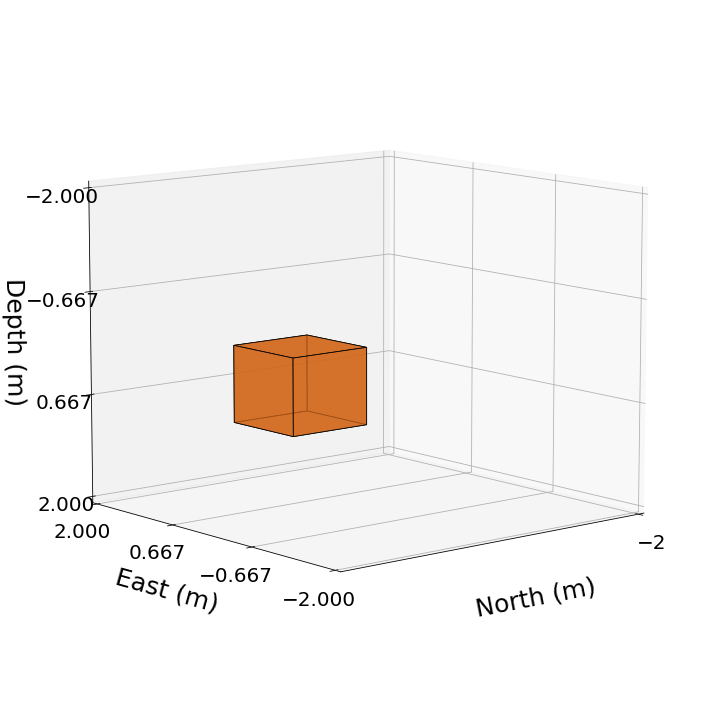

In [11]:
# Plot the main 3D source
figure = plt.figure(figsize=(10,10))

ax = figure.gca(projection = '3d')
#ax.set_title('Vertical dike model', size = 18)

#x1, x2, y1, y2, z1, z2 = fonte_crustal_mag[:6]
v = np.array([[x1, y1, z2], [x1, y2, z2], [x2, y2, z2], [x2, y1, z2], 
                 [x1, y1, z1], [x1, y2, z1], [x2, y2, z1], [x2, y1, z1]])
vert =  [[v[0],v[1],v[2],v[3]], 
         [v[0],v[1],v[5],v[4]], 
         [v[1],v[2],v[6],v[5]],
         [v[2],v[3],v[7],v[6]], 
         [v[3],v[0],v[4],v[7]], 
         [v[4],v[5],v[6],v[7]]]

fig01 = Poly3DCollection(vert, alpha = 0.75, linewidths = 0.75, edgecolors = 'k')
fig01.set_facecolor('chocolate')
ax.add_collection3d(fig01)
#individuo0 = ax.scatter(coodX1, coodY1, coodZ1, c=incl1, depthshade=True, cmap='jet', s = 200.0)

# Define the scale of the projection
x_scale = 1.2
y_scale = 1.2
z_scale = 1.
scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3] = 1.
def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)
ax.get_proj = short_proj

# Labels
ax.set_xlabel('North (m)', size = 25, labelpad = 30)
ax.set_ylabel('East (m)', size = 25, labelpad = 30)
ax.set_zlabel('Depth (m)', size = 25, labelpad = 30)
ax.set_xlim(-2.0, 2.0)
ax.set_ylim(-2.0, 2.0)
ax.set_zlim(-2.0, 2.0)
ax.set_xticks(np.arange(-2.0, 2.0, 4))
ax.set_yticks(np.linspace(-2.0, 2.0, 4))
ax.set_zticks(np.linspace(-2.0, 2.0, 4))
ax.tick_params(labelsize = 20, pad = 10)

# Visualization angle
ax.view_init(190, 130)

plt.tight_layout(True)
#plt.savefig('figs/dikemodel-r1.png', dpi = 300, bbox_inches = 'tight', transparent = True)
#plt.savefig('figs/dikemodel-r1.pdf', dpi = 300, bbox_inches = 'tight', transparent = True)
plt.show()

In [12]:
xcood = v[:,0]
ycood = v[:,1]
zcood = v[:,2]
print(len(v))
print(v)

8
[[0. 0. 1.]
 [0. 1. 1.]
 [1. 1. 1.]
 [1. 0. 1.]
 [0. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [1. 0. 0.]]


In [13]:
distancia = dist_euclidiana(xcood,ycood,zcood)

In [14]:
print(distancia)
print(np.shape(distancia))
print(np.var(distancia))

[[0.         1.         1.41421356 1.         1.         1.41421356
  1.73205081 1.41421356]
 [1.         0.         1.         1.41421356 1.41421356 1.
  1.41421356 1.73205081]
 [1.41421356 1.         0.         1.         1.73205081 1.41421356
  1.         1.41421356]
 [1.         1.41421356 1.         0.         1.41421356 1.73205081
  1.41421356 1.        ]
 [1.         1.41421356 1.73205081 1.41421356 0.         1.
  1.41421356 1.        ]
 [1.41421356 1.         1.41421356 1.73205081 1.         0.
  1.         1.41421356]
 [1.73205081 1.41421356 1.         1.41421356 1.41421356 1.
  0.         1.        ]
 [1.41421356 1.73205081 1.41421356 1.         1.         1.41421356
  1.         0.        ]]
(8, 8)
0.24148300898706182


In [15]:
grafos, TSG = create_graph(v, distancia)

In [25]:
var_ = theta_var(TSG)
print(var_)

0.0


In [16]:
dm1 = []
for (u, v, wt) in TSG.edges.data('weight'):
    dm1.append(wt)

print(dm1)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [17]:
#teste
t_a = [1.5, 1.5, 1.5, 1.5, 1.5]
t_r = np.var(t_a)
t_n = t_r/(len(t_a))
t_array = np.array(t_a)
t_m = np.mean(t_array)
#t_m1 = mean(t_a)
print(t_m)
#print(t_m1)
print(t_r)
print(t_n)

1.5
0.0
0.0


In [18]:
dm3 = np.array(dm1)
n = len(dm1)
variancia = np.var(dm3)/n
print(variancia)
print(n)

0.0
7


In [19]:
'''node_xyz1 = np.array([pos[v1] for v1 in sorted(TSG)])
edge_xyz1 = np.array([(pos[u1], pos[v1]) for u1, v1 in TSG.edges()])
# Create the 3D figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz1.T, s=100, ec="w")

# Plot the edges
for vizedge1 in edge_xyz1:
    #print(vizedge)
    ax.plot(*vizedge1.T, color="tab:gray")


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(True)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    plt.title('Minimum spanning tree', fontsize = 30)

    ax.set_xticks(np.linspace(0, 10, 5))
    ax.set_yticks(np.linspace(0, 10, 5))
    ax.set_zticks(np.linspace(0, 10, 5))
    ax.tick_params(labelsize = 20)


_format_axes(ax)
fig.tight_layout()
plt.show()'''

'node_xyz1 = np.array([pos[v1] for v1 in sorted(TSG)])\nedge_xyz1 = np.array([(pos[u1], pos[v1]) for u1, v1 in TSG.edges()])\n# Create the 3D figure\nfig = plt.figure(figsize=(8, 8))\nax = fig.add_subplot(111, projection="3d")\n\n# Plot the nodes - alpha is scaled by "depth" automatically\nax.scatter(*node_xyz1.T, s=100, ec="w")\n\n# Plot the edges\nfor vizedge1 in edge_xyz1:\n    #print(vizedge)\n    ax.plot(*vizedge1.T, color="tab:gray")\n\n\ndef _format_axes(ax):\n    """Visualization options for the 3D axes."""\n    # Turn gridlines off\n    ax.grid(True)\n    # Suppress tick labels\n    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):\n        dim.set_ticks([])\n    # Set axes labels\n    ax.set_xlabel("x")\n    ax.set_ylabel("y")\n    ax.set_zlabel("z")\n    \n    plt.title(\'Minimum spanning tree\', fontsize = 30)\n\n    ax.set_xticks(np.linspace(0, 10, 5))\n    ax.set_yticks(np.linspace(0, 10, 5))\n    ax.set_zticks(np.linspace(0, 10, 5))\n    ax.tick_params(labelsize = 20)\n\n\n_for

In [20]:
population1 = {'xmax': 5000.0,
                'xmin': -5000.0,
                'ymax': 5000.0,
                'ymin': -5000.0,
                'zlim': 7000.0,
                'z_min': 0.0,
                'n_dip': 5,
                'n_pop': 10,
                'inclmax': 5.0,
                'inclmin': -5.0,
                'declmax': 5.0,
                'declmin': -5.0,
                'mmax': 2.5,
                'mmin': 1.5,
                'homogeneo': True
                }

In [21]:
populacao = Operators_array.create_population(**population1)

In [22]:
theta, MST = theta_value(populacao)

In [30]:
print(theta)
print(len(theta))
a_ = len(populacao[1])-1
print(a_)

[4476466.013601391, 7722728.997817827, 11510066.786573052, 1921469.4445453766, 24216975.732862577, 12410284.329648977, 4106707.1757495957, 5844033.677330955, 17228064.08481078, 13570281.06870536]
10
5


In [24]:
th = [1, 2, 5, 6]
for i in th:
    print(i)

1
2
5
6


In [32]:
c_ = populacao[1]
v_ = c_[len(populacao[1])-1,2]
print(v_)

1.866365525458497


In [29]:
populacao[1]

array([[-2.22465504e+03,  1.37507344e+03,  2.40637170e+03],
       [ 2.68651967e+03,  2.28492454e+03,  5.22016371e+03],
       [-8.42521681e+02,  2.72390073e+03,  5.10227018e+03],
       [ 5.71391453e+02,  1.78822942e+03,  1.97143145e+03],
       [-1.43761080e+03, -4.89371606e+03,  3.43308011e+03],
       [ 2.34982801e+00, -2.28952549e+00,  1.86636553e+00]])

In [3]:
teste_aaa = [1.0, 2.0, 3.5, 0.5, 7.4]
for i in range(5):
    n_t = len(teste_aaa)
    print(teste_aaa[n_t - 1])

7.4
7.4
7.4
7.4
7.4
